In [1]:
# System Libraries
import math

# Data analysis
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)

# Plotting tools
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Models
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
%matplotlib inline

# Machine Learning tools
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.model_selection import cross_val_predict, cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline



### 0. Load data and perform column translation

In [2]:
# Load files to dataframes
raw_data = pd.read_csv('./labeled_dataset.csv')
raw_predict = pd.read_csv('./scoring_dataset.csv')

In [3]:
# Delete the index column
data = raw_data.copy()
data_predict = raw_predict.copy()
del data['index']
del data_predict['index']

In [4]:
# Make sure data is loaded correctly
data.head(2)

,Age,Prime mensuelle,Categorie socio professionnelle,Kilometres parcourus par mois,Coefficient bonus malus,Type de vehicule,Score CRM,Niveau de vie,Marque,Salaire annuel,Score credit,Cout entretien annuel,Benefice net annuel
0,58.0,40.0,Etudiant,973,106,SUV,164,3762,Peugeot,20420,309,801,54.998558
1,26.0,27.0,Ouvrier,637,95,5 portes,126,3445,Renault,25750,135,667,7.840930


In [5]:
data_predict.head(2)

,Age,Prime mensuelle,Categorie socio professionnelle,Kilometres parcourus par mois,Coefficient bonus malus,Type de vehicule,Score CRM,Niveau de vie,Marque,Salaire annuel,Score credit,Cout entretien annuel
0,19.0,16.0,Cadre,746,108,Utilitaire,121,4956,Toyota,31600,401,756
1,21.0,14.0,Cadre,694,106,5 portes,125,4531,Opel,34900,833,719


In [6]:
# A dictionary for column translation
word_translation = {
    'Age': 'age',
    'Prime mensuelle': 'premium_monthly',
    'Categorie socio professionnelle': 'job_category',
    'Kilometres parcourus par mois': 'km_travelled_monthly',
    'Coefficient bonus malus': 'coefficient_bonus_malus',
    'Type de vehicule': 'vehicle_type',
    'Score CRM': 'crm_score',
    'Niveau de vie': 'standard_of_living',
    'Marque': 'car_brand',
    'Salaire annuel': 'annual_salary',
    'Score credit': 'credit_score',
    'Cout entretien annuel': 'annual_maintenance_cost',
    'Benefice net annuel': 'annual_net_profit'
}

In [7]:
# Translate column by column
data_column = [ word_translation[x] for x in data.columns]
predict_column = [ word_translation[x] for x in data_predict.columns]

# Set new column names
data.columns = data_column
data_predict.columns = predict_column

In [8]:
data.head(2)

,age,premium_monthly,job_category,km_travelled_monthly,coefficient_bonus_malus,vehicle_type,crm_score,standard_of_living,car_brand,annual_salary,credit_score,annual_maintenance_cost,annual_net_profit
0,58.0,40.0,Etudiant,973,106,SUV,164,3762,Peugeot,20420,309,801,54.998558
1,26.0,27.0,Ouvrier,637,95,5 portes,126,3445,Renault,25750,135,667,7.840930


In [9]:
data_predict.head(2)

,age,premium_monthly,job_category,km_travelled_monthly,coefficient_bonus_malus,vehicle_type,crm_score,standard_of_living,car_brand,annual_salary,credit_score,annual_maintenance_cost
0,19.0,16.0,Cadre,746,108,Utilitaire,121,4956,Toyota,31600,401,756
1,21.0,14.0,Cadre,694,106,5 portes,125,4531,Opel,34900,833,719


### 1. Data exploration & Cleansing

**Observation**

* From the describe table below, we can see that there are missing values in the **age** and **premium_monthly** columns. I would like to fix them first.

In [10]:
# Have an overview on data
data.describe()

/home/victor/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,age,premium_monthly,km_travelled_monthly,coefficient_bonus_malus,crm_score,standard_of_living,annual_salary,credit_score,annual_maintenance_cost,annual_net_profit
count,983.000000,989.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.953204,18.754297,605.675000,100.008000,134.724000,4207.239000,29553.820000,493.933000,792.998000,16.975844
std,17.985224,13.162842,232.394446,14.854379,20.389791,2665.071559,18054.980164,288.958869,99.422638,19.436137
min,0.000000,0.000000,200.000000,50.000000,79.000000,-558.000000,880.000000,1.000000,520.000000,-35.720831
25%,NaN,NaN,411.000000,90.000000,121.000000,2335.000000,16795.000000,237.000000,726.000000,5.991101
50%,NaN,NaN,614.000000,100.000000,134.000000,3652.500000,25955.000000,493.500000,794.000000,14.386086
75%,NaN,NaN,807.000000,110.000000,147.000000,5491.250000,38067.500000,731.750000,863.000000,30.344179
max,198.000000,80.000000,999.000000,154.000000,254.000000,23673.000000,165760.000000,999.000000,1145.000000,78.114678


#### Age

**Observation**:

* As can be seen from the list above, there are 0 and NaN values in the list. I am going to treat them both as NaN There are also several entries with age values larger than 100. They are [194, 195, 168, 124, 198, 176, 145, 137, 157] Oldest people in the world is 122 years old, I decided to treat ages larger than 122 as null.

In [11]:
data['age'].unique()

array([  58.,   26.,   27.,   22.,   60.,   25.,   54.,   18.,   48.,
         30.,   24.,   49.,   44.,   29.,   39.,   35.,   33.,   34.,
         40.,   36.,   28.,   nan,   55.,   70.,   20.,   42.,   50.,
         23.,   21.,   32.,   19.,    0.,   43.,   41.,   47.,   31.,
         38.,   79.,   52.,   64.,   37.,   65.,   53.,  194.,   61.,
         67.,   56.,   45.,  195.,   46.,   69.,  168.,   68.,   59.,
         51.,  124.,   57.,   62.,   75.,   73.,   76.,   66.,   80.,
         74.,  198.,  176.,  145.,   63.,   71.,   87.,   83.,  137.,  157.])

In [12]:
# Treat customers age > 100 as None
data.loc[(data['age']==0) & (data['age']>100), 'age'] = None
data_predict.loc[(data_predict['age']==0) & (data_predict['age']>100), 'age'] = None

# Set None ages to the median
age_median = data['age'].median()
data.loc[data['age'].isnull(), 'age'] = age_median
data_predict.loc[data_predict['age'].isnull(), 'age'] = age_median

#### premium_monthly

**Observation**:
* Besides the null values, the **zero** values do not make sense either. Since all of the entries here are data about our clients, we expect that they are paying certain amount of premium. As a result, I will set the zero and null values of the **premium_monthly** column to the **median** value of the whole column.

In [13]:
data['premium_monthly'].unique()

array([ 40.,  27.,  26.,   8.,  20.,  18.,  22.,  37.,  19.,  23.,  44.,
         6.,  70.,  17.,  42.,  13.,  nan,  11.,  12.,  14.,  25.,  10.,
        31.,  15.,  32.,   3.,   2.,   1.,  30.,  38.,  41.,  48.,   9.,
        21.,  57.,  43.,  16.,   5.,  24.,  33.,  28.,   7.,   4.,  36.,
        55.,  34.,  29.,  52.,  35.,   0.,  45.,  46.,  39.,  80.,  54.,
        64.,  61.,  50.,  47.,  68.,  72.,  49.,  74.,  63.,  58.,  56.])

In [14]:
# Set 'premium_monthly' zero values to None
data.loc[data['premium_monthly']==0, 'premium_monthly'] = None
data_predict.loc[data_predict['premium_monthly']==0, 'premium_monthly'] = None

# Set the None values to the median
premium_med = data['premium_monthly'].median()
data.loc[data['premium_monthly'].isnull(), 'premium_monthly'] = premium_med
data_predict.loc[data_predict['premium_monthly'].isnull(), 'premium_monthly'] = premium_med

#### job_category
**Observation**:
* The job_categories are Executive ('Cadre'), Student ('Etudiant'), Employee ('Ouvrier'), Sans emploi ('unemployed'), Non-salaried workers ('Travailleur non salarie'). 
* The correlation matrix shows that the dummied **job_category** columns are not quite related to our target variable
* As can be seen from the table above, this column does not make sense, just like what the document says. The **age** of 'students' are similar to that of the others (usually younger). The **annual_salary** of 'executive' is even lower than that of the 'students'. The **annual_salary** of the 'Non-salaried workers' are the highest among all. The observations tell me that I can't use the conventional ways to approach this problem.

In [15]:
data['job_category'].value_counts()

Cadre                      345
Etudiant                   291
Ouvrier                    218
Sans emploi                 94
Travailleur non salarie     52
Name: job_category, dtype: int64

In [16]:
data.groupby(data['job_category']).mean()

,age,premium_monthly,km_travelled_monthly,coefficient_bonus_malus,crm_score,standard_of_living,annual_salary,credit_score,annual_maintenance_cost,annual_net_profit
job_category,,,,,,,,,,
Cadre,37.739130,19.231884,606.489855,101.643478,136.881159,4044.452174,28370.782609,495.040580,790.034783,15.877409
Etudiant,34.010309,18.436426,598.484536,99.408935,133.408935,4245.549828,29825.360825,497.639175,798.979381,20.297029
Ouvrier,34.211009,18.541284,596.857798,99.018349,133.972477,4266.389908,30470.779817,488.532110,795.000000,14.910130
Sans emploi,37.851064,18.457447,619.329787,98.702128,133.819149,4047.819149,27620.957447,495.074468,779.638298,17.470605
Travailleur non salarie,37.557692,19.750000,652.788462,99.019231,132.557692,5113.076923,35533.076923,486.423077,794.942308,13.443399


In [17]:
# Encode the 'job_category' column of data
dummies = pd.get_dummies(data['job_category'])
new_data = pd.concat([data, dummies], axis=1)
del new_data['job_category']
data = new_data

# Encode the 'job_category' column of data_predict
dummies_predict = pd.get_dummies(data_predict['job_category'])
new_data_predict = pd.concat([data_predict, dummies_predict], axis=1)
del new_data_predict['job_category']
data_predict = new_data_predict

#### vehicle_type
**Observations**:
* Good! The **correlation matrix** tells us that dummied 'vehicle_type' columns are great features that are quite related to the 'annual_net_profit'! 
* From the **groupby** table, we can see from the last column, the mean values of 'annual_net_profit' of each 'vehicle_type' differ significantly from each other.

In [18]:
data['vehicle_type'].value_counts()

5 portes      378
SUV           319
3 portes      223
Utilitaire     80
Name: vehicle_type, dtype: int64

In [19]:
data.groupby(data['vehicle_type']).mean()

,age,premium_monthly,km_travelled_monthly,coefficient_bonus_malus,crm_score,standard_of_living,annual_salary,credit_score,annual_maintenance_cost,annual_net_profit,Cadre,Etudiant,Ouvrier,Sans emploi,Travailleur non salarie
vehicle_type,,,,,,,,,,,,,,,
3 portes,35.991031,19.125561,592.784753,99.394619,133.560538,4079.986547,28755.470852,486.645740,791.076233,-7.222840,0.354260,0.246637,0.233184,0.116592,0.049327
5 portes,34.701058,19.095238,627.589947,100.568783,134.544974,4112.343915,29041.613757,496.497354,793.825397,12.005804,0.341270,0.285714,0.206349,0.111111,0.055556
SUV,37.197492,18.589342,591.830721,99.304075,135.184953,4450.808777,30907.586207,491.322884,791.510972,31.313410,0.344828,0.338558,0.210031,0.056426,0.050157
Utilitaire,35.962500,17.387500,593.262500,101.875000,136.975000,4039.100000,28801.250000,512.537500,800.375000,50.742063,0.337500,0.250000,0.262500,0.100000,0.050000


In [20]:
# Encode the 'vehicle_type' column of data
dummies = pd.get_dummies(data['vehicle_type'])
new_data = pd.concat([data, dummies], axis=1)
del new_data['vehicle_type']
data = new_data

# Encode the 'vehicle_type' column of data_predict
dummies_predict = pd.get_dummies(data_predict['vehicle_type'])
new_data_predict = pd.concat([data_predict, dummies_predict], axis=1)
del new_data_predict['vehicle_type']
data_predict = new_data_predict

#### car_brand
**Observations**:
* Similar to the **job_category**, the **car_brand** seems to be not quite relevant in this dataset. Anyway, make it into dummies first and then decide use it or not later.

In [21]:
data.groupby(data['car_brand']).describe()

age  premium_monthly  km_travelled_monthly  \
car_brand                                                             
Citroen    count  196.000000       196.000000            196.000000   
           mean    35.704082        20.255102            618.750000   
           std     16.436488        13.628636            232.618944   
           min      0.000000         2.000000            205.000000   
           25%     27.000000        11.000000            424.250000   
           50%     32.000000        17.500000            635.500000   
           75%     41.000000        26.250000            808.000000   
           max    194.000000        70.000000            995.000000   
Opel       count   47.000000        47.000000             47.000000   
           mean    40.255319        20.489362            583.893617   
           std     24.706510        13.323520            252.132059   
           min     18.000000         1.000000            209.000000   
           25%     28.000000        12.000000            360.000000   
           50%     34.000000        18.000000            591.000000   
           75%     44.000000        27.500000            837.000000   
           max    157.000000        68.000000            992.000000   
Peugeot    count  270.000000       270.000000            270.000000   
           mean    37.140741        18.381481            588.862963   
           std     19.471708        13.157850            234.336729   
           min      0.000000         1.000000            204.000000   
           25%     26.000000         9.000000            383.250000   
           50%     33.500000        15.000000            574.000000   
           75%     43.000000        24.000000            784.250000   
           max    195.000000        70.000000            999.000000   
Renault    count  235.000000       235.000000            235.000000   
           mean    35.642553        18.834043            612.004255   
           std     16.790053        12.919959            228.264214   
           min     18.000000         1.000000            200.000000   
           25%     26.000000        10.000000            418.000000   
           50%     33.000000        16.000000            645.000000   
           75%     40.000000        26.000000            796.000000   
           max    176.000000        80.000000            994.000000   
Toyota     count   88.000000        88.000000             88.000000   
           mean    33.170455        18.477273            613.215909   
           std     12.107964        13.643218            218.910912   
           min      0.000000         2.000000            207.000000   
           25%     25.000000         9.000000            434.500000   
           50%     32.000000        16.000000            619.500000   
           75%     40.000000        23.250000            815.500000   
           max     66.000000        72.000000            997.000000   
Volkswagen count  112.000000       112.000000            112.000000   
           mean    33.071429        17.669643            608.535714   
           std     12.466687        11.615762            247.029302   
           min     18.000000         3.000000            218.000000   
           25%     24.000000        10.000000            377.750000   
           50%     31.000000        15.500000            616.000000   
           75%     39.000000        22.250000            825.000000   
           max     79.000000        61.000000            992.000000   

                  coefficient_bonus_malus   crm_score  standard_of_living  \
car_brand                                                                   
Citroen    count               196.000000  196.000000          196.000000   
           mean                101.198980  135.678571         4209.954082   
           std                  15.450706   20.232083         2548.270843   
           min                  61.000000   90.000000         -558.000000   
           2

In [22]:
# Encode the 'car_brand' column of data
dummies = pd.get_dummies(data['car_brand'])
new_data = pd.concat([data, dummies], axis=1)
del new_data['car_brand']
data = new_data

# Encode the 'car_brand' column of data_predict
dummies_predict = pd.get_dummies(data_predict['car_brand'])
new_data_predict = pd.concat([data_predict, dummies_predict], axis=1)
del new_data_predict['car_brand']
data_predict = new_data_predict

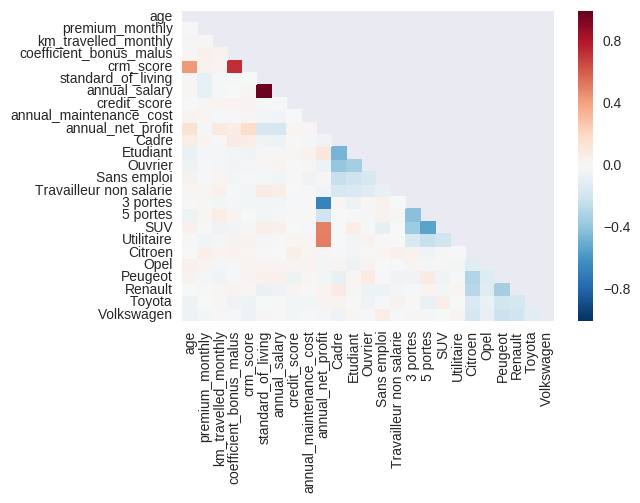

In [23]:
corr = data.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, vmax=1.0)

In [24]:
data.head(5)

,age,premium_monthly,km_travelled_monthly,coefficient_bonus_malus,crm_score,standard_of_living,annual_salary,credit_score,annual_maintenance_cost,annual_net_profit,Cadre,Etudiant,Ouvrier,Sans emploi,Travailleur non salarie,3 portes,5 portes,SUV,Utilitaire,Citroen,Opel,Peugeot,Renault,Toyota,Volkswagen
0,58.0,40.0,973,106,164,3762,20420,309,801,54.998558,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,26.0,27.0,637,95,126,3445,25750,135,667,7.840930,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,27.0,26.0,978,136,153,986,6790,786,696,46.078889,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,22.0,8.0,771,96,111,2366,15140,320,765,-11.048213,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,60.0,20.0,758,101,149,1441,12850,287,808,1.180078,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [25]:
data_predict.head(5)

,age,premium_monthly,km_travelled_monthly,coefficient_bonus_malus,crm_score,standard_of_living,annual_salary,credit_score,annual_maintenance_cost,Cadre,Etudiant,Ouvrier,Sans emploi,Travailleur non salarie,3 portes,5 portes,SUV,Utilitaire,Citroen,Opel,Peugeot,Renault,Toyota,Volkswagen
0,19.0,16.0,746,108,121,4956,31600,401,756,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,21.0,14.0,694,106,125,4531,34900,833,719,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,29.0,13.0,740,110,140,9541,62820,890,1027,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,33.0,2.0,970,99,132,6536,45450,990,964,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,23.0,6.0,408,100,127,10985,74270,647,768,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## 2. Model construction

** Strategy **
1. Divide the raw data into train data and test data.
2. Choose a model which can be used to solve **regression** problem
3. Using train data and **cross-validation** method to evaluate the model performance, the metrics to use is **mean square error**
4. Plot the **learning curve** to spot **bias/variance** problem (Andrew Ng's approach)
5. Possible steps: Feature selection, Polynomial Features, More complex Model, Regulization, Parameters tuning...
6. Repeat 2-5
7. Deliver the best model

**Special notes:**
* A list of **tuple** is used to store the **Model condition**, **RMSE scrore on cross-validation set**, and a **dictionary** of **feature-importance/coefficient** pair. The list will be used for the final analysis part. 
* Due to the randomness **train_test_split**, the values obtained for the model might be slightly different from the value I wrote on the notebook. However, the values are still good reference and can provide the general understanding. 

**Candidate Models**
1. Linear Regression
2. Ridge Regression (L2 regularization)
3. Random Forest Regressor (Ensembled model)

### 2.0 Train-test data split & Helpher functions
Train data 70%, Test data 30%

In [26]:
# Split the traning and testing data
train_data = data.copy()
features = train_data.loc[:, data.columns != 'annual_net_profit']
target = train_data.loc[:, 'annual_net_profit']
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.3, random_state=42)

# The analysis tutple for final analysis
analysis_tuple_list = []

In [27]:
# A function which prints the residual diagram
def plot_residual(predicted, residual):
    fig, ax = plt.subplots()
    ax.scatter(predicted, residual)
    ax.axhline(y=0, color='k')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Residual')
    plt.show()

In [28]:
# Cross-validation performance testing on training data
def performance_cv(model, model_name, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    cv_scores = cross_val_score(model, X_train, y_train, 
                                scoring='neg_mean_squared_error', cv=10)
    print "The RMSE cross-validation score of {} is {}".format(model_name, math.sqrt(-cv_scores.mean()))
    return math.sqrt(-cv_scores.mean())

In [29]:
# Performance testing on testing data
def performance_test(model, model_name, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    model.fit(X_train, y_train)
    predicted = model.predict(X_test)
    score = mean_squared_error(y_test, predicted)
    print "The RMSE score of the {} on test data is {}".format(model_name, math.sqrt(score))
    return math.sqrt(score)

In [30]:
# The learning curve which is used to spot variance and bias problems
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("N (Training Set Sizes)")
    plt.ylabel("Mean Square Error")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs,
        scoring=make_scorer(mean_squared_error), train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training error")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation error")

    plt.legend(loc="best")
    plt.grid()
    return plt

In [31]:
# A support functions which finds the best threshold for SelectFromModel
def find_the_best_threshold(model, low, high, step_size, X_train=X_train, y_train=y_train):
    threshold = 0.0
    best_threshold = 0
    best_score = 10000
    while True:
        model = model.fit(X_train, y_train)
        selector = SelectFromModel(model, threshold=threshold, prefit=True)
        X_train_new = selector.transform(X_train)
        cv_scores = cross_val_score(linear_regression, X_train_new, y_train, 
                                    scoring='neg_mean_squared_error', cv=10)
        score = math.sqrt(-cv_scores.mean())
        if score < best_score:
            best_score = score
            best_threshold = threshold
        threshold += step_size
        if threshold >= high:
            print "The best threshold between {} and {} is {}".format(low, high, best_threshold)
            return best_threshold

### 2.1.1 Linear Regression with given features

**Cross-validation RMSE**: 6.77842594397

**Observation & Next Step**:
* Clearly the linear regression is **underfitting** the training set. As shown in the learning curve, the training error increases as the number of training examples increases and the cross-validation error and training error converge at certain high level. This is a clear scenario of **high bias**.
* Possible measures: **Adding more features**, **Try another model**

<module 'matplotlib.pyplot' from '/home/victor/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

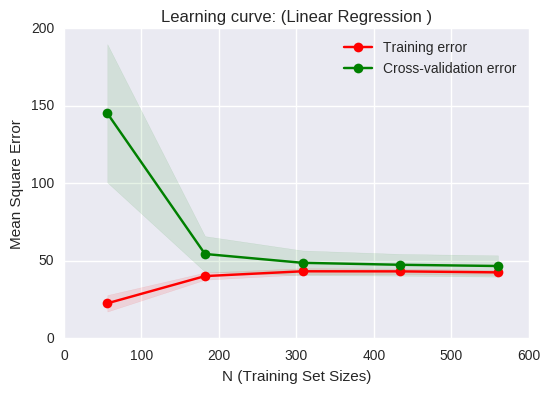

In [32]:
# Initiate the linear regression model and plot the learning curve with default data
linear_regression = linear_model.LinearRegression()
title = "Learning curve: (Linear Regression )"
plot_learning_curve(linear_regression, title, X_train, y_train, cv=5, n_jobs=-1)

In [33]:
# Take the cv score of default model as the basic score
basic_score = performance_cv(linear_regression, 'linear regression')

# Get the feature list 
linear_regression.fit(X_train, y_train)
feature_list = sorted(zip(X_train.columns, linear_regression.coef_), 
                          key=lambda x: abs(x[1]), reverse=True)

# Add into the analysis tuple
analysis_tuple_list.append(('linear regression with plain features', basic_score, feature_list))

The RMSE cross-validation score of linear regression is 6.77716086154


### 2.1.2 Linear Regression with Polynomial features of degree 2

**Cross-validation RMSE**: 2.52267408034

**Observation**
* At first glance the graph looks quite scaring, the cross-validation error peaks at around 7000 at the begining. However, as the traning set grows, the cross-validation error decreases drastically and finally converges with the training error. The second diagram shows that eventually the cross-validation error plunges as low as around 5. 
* Overall the model performance is pleasing. The trend is what we would like to see. Next I will perform feature selection to further minimize the **variance** of the model.

In [34]:
# Get polynomial features of all datasets
poly = PolynomialFeatures(2)
X_train_transformed = poly.fit_transform(X_train)
X_test_transformed = poly.fit_transform(X_test)

# Obtain polynomial feature names
feature_name = poly.get_feature_names(X_train.columns)

<module 'matplotlib.pyplot' from '/home/victor/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

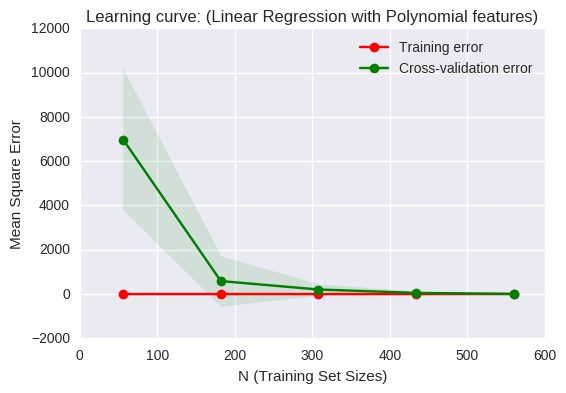

In [35]:
# Initialize lr model and plot learning curve
linear_regression = linear_model.LinearRegression()
title = "Learning curve: (Linear Regression with Polynomial features)"
plot_learning_curve(linear_regression, title, X_train_transformed, y_train, cv=5, n_jobs=-1)

In [36]:
# Get cv performance
basic_poly_score = performance_cv(linear_regression, 'linear regression with poly 2 features', X_train=X_train_transformed)

# Get 'feature_name' - 'Importance' pairs
linear_regression.fit(X_train_transformed, y_train)
feature_list = sorted(zip(feature_name, linear_regression.coef_), 
                          key=lambda x: abs(x[1]), reverse=True)

# Add into analysis tuple list
analysis_tuple_list.append(('linear regression with poly 2 features', basic_poly_score, feature_list))

The RMSE cross-validation score of linear regression with poly 2 features is 2.52267408034


### 2.1.3 Linear Regression with Polynomial features of degree 2, features selected

**Cross-validation RMSE**: 1.8968718596

**Observation**
I would like to find the best **threshold** value for SelectFromModel. The features under the **threshold** value will be removed. Here I sampled some **threshold** value spaces and try to find the best value within the ranges. Then I compare the best values. 
* In the range 0.0001 to 0.02, 0.0001 is the best value.
* In the range 0.00001 to 0.0001: 0.00004 is the best value.
* In the range 0.000001 to 0.00004: 0.00004 is the best value.
* Compare the values and found out that 0.00004 is the best
* To save the computation effort, I use **min** as the step size. It might miss the best value, however, **0.000035** seems to be an acceptable value.

In [37]:
# Reset linear regression model
linear_regression = linear_model.LinearRegression()

In [38]:
# Find the best threshold for SelectFromModel
find_the_best_threshold(linear_regression, 0.0001, 0.02, 0.0001, X_train=X_train_transformed)
find_the_best_threshold(linear_regression, 0.00001, 0.0001, 0.00001, X_train=X_train_transformed)
find_the_best_threshold(linear_regression, 0.000001, 0.00004, 0.000001, X_train=X_train_transformed)

The best threshold between 0.0001 and 0.02 is 0.0001
The best threshold between 1e-05 and 0.0001 is 4e-05
The best threshold between 1e-06 and 4e-05 is 4e-05


3.999999999999998e-05

<module 'matplotlib.pyplot' from '/home/victor/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

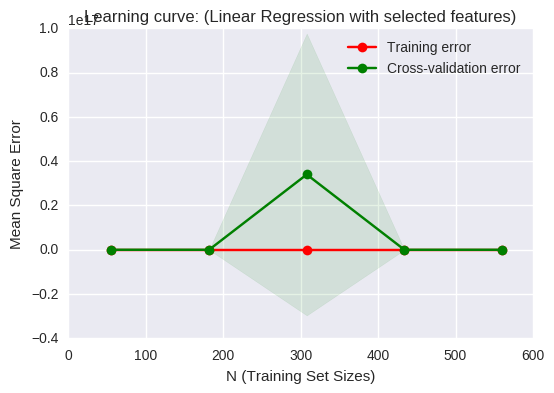

In [39]:
# SelectFromModel with the best threshold
linear_regression = linear_regression.fit(X_train_transformed, y_train)
model_linear = SelectFromModel(linear_regression, threshold=0.000035, prefit=True)

# Feature selection
X_train_new = X_train_selected_lr = model_linear.transform(X_train_transformed)
X_test_selected_lr = model_linear.transform(X_test_transformed)

# Plot learning curve
title = "Learning curve: (Linear Regression with selected features)"
plot_learning_curve(linear_regression, title, X_train_new, y_train, cv=5, n_jobs=-1)

In [40]:
# Get cv performance
basic_selected_score = performance_cv(linear_regression, 'linear regression with selected poly 2 features', X_train=X_train_new)

# Get the names of the selected features
selected_feature_name = [x[0] for x in zip(feature_name, model_linear.get_support()) if x[1]==True]

# Get 'feature' - 'coefficient' pair
linear_regression.fit(X_train_new, y_train)
feature_list = sorted(zip(selected_feature_name, linear_regression.coef_), 
                          key=lambda x: abs(x[1]), reverse=True)

# Append to the analysis tuple
analysis_tuple_list.append(('linear regression with selected poly 2 features', basic_selected_score, feature_list))

The RMSE cross-validation score of linear regression with selected poly 2 features is 1.94213052862


### 2.1.4 Ridge Regression with Polynomial features of degree 2, features selected

**Cross-validation RMSE**: 1.7998760833246206

**Observations**:
* Here I fed the features selected from the previous step into the Ridge regression model. The result is satisfying. **Alpha** is the regularization strength, a parameter to tune for this model.
* The good threshold for ridge regression is **0.00004**

In [41]:
# Ridge regression Model initiation
ridge_regression = linear_model.Ridge()

# Find the best threshold for SelectFromModel
find_the_best_threshold(ridge_regression, 0.0001, 0.02, 0.0001, X_train=X_train_transformed)
find_the_best_threshold(ridge_regression, 0.00001, 0.0001, 0.00001, X_train=X_train_transformed)
find_the_best_threshold(ridge_regression, 0.000001, 0.00004, 0.000001, X_train=X_train_transformed)

The best threshold between 0.0001 and 0.02 is 0.0001
The best threshold between 1e-05 and 0.0001 is 4e-05
The best threshold between 1e-06 and 4e-05 is 4e-05


3.999999999999998e-05

<module 'matplotlib.pyplot' from '/home/victor/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

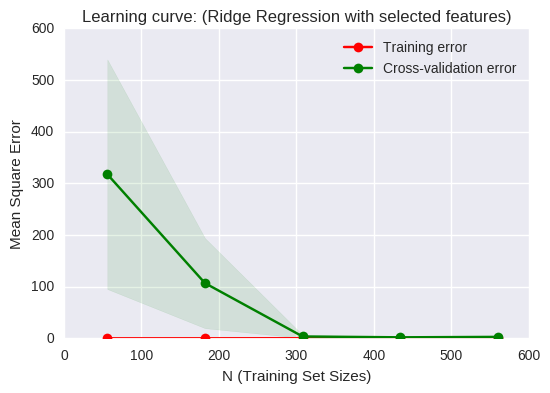

In [42]:
# SelectFromModel with the best threshold
ridge_regression = ridge_regression.fit(X_train_transformed, y_train)
model_ridge = SelectFromModel(ridge_regression, threshold=0.00004, prefit=True)

# Feature selection
X_train_new = X_train_selected_ridge = model_ridge.transform(X_train_transformed)
X_test_selected_ridge = model_ridge.transform(X_test_transformed)

# Data transformation for final prediction
data_predict_transformed = poly.fit_transform(data_predict)
data_predict_selected = model_ridge.transform(data_predict_transformed)

# Plot the learning curve
title = "Learning curve: (Ridge Regression with selected features)"
plot_learning_curve(ridge_regression, title, X_train_new, y_train, cv=5, n_jobs=-1)

In [43]:
# Get cv performance
ridge_score = performance_cv(ridge_regression, 'Ridge regression with selected poly 2 features', 
                             X_train=X_train_new)

# Get the names of selected polynomial features
selected_feature_name = [x[0] for x in zip(feature_name, model_ridge.get_support()) if x[1]==True]

# Get 'feature' - 'coefficient' pair
ridge_regression.fit(X_train_new, y_train)
ridge_feature_list = sorted(zip(selected_feature_name, ridge_regression.coef_), 
                          key=lambda x: abs(x[1]), reverse=True)

# Append to the analysis tuple
analysis_tuple_list.append(('Ridge regression with selected poly 2 features', ridge_score, ridge_feature_list))

The RMSE cross-validation score of Ridge regression with selected poly 2 features is 1.80361038413


### 2.2 Random Forest Regressor with selected Polynomial features of degree 2

**Cross-validation RMSE:** 3.40588337865

**Observations:**
* The good threshold for model selection is **0.000006**
* It seems that random forest regressor cannot beat ridge regression in our dataset

In [44]:
# Random Forest Regressor model initiation
rf_r = RandomForestRegressor(n_estimators=50, n_jobs=4)

# Find the best threshold for SelectFromModel
find_the_best_threshold(rf_r, 0.0, 0.02, 0.001, X_train=X_train_transformed)
find_the_best_threshold(rf_r, 0.0, 0.0001, 0.00001, X_train=X_train_transformed)
find_the_best_threshold(rf_r, 0.0, 0.00001, 0.000001, X_train=X_train_transformed)

The best threshold between 0.0 and 0.02 is 0.0
The best threshold between 0.0 and 0.0001 is 9e-05
The best threshold between 0.0 and 1e-05 is 8e-06


8e-06

<module 'matplotlib.pyplot' from '/home/victor/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

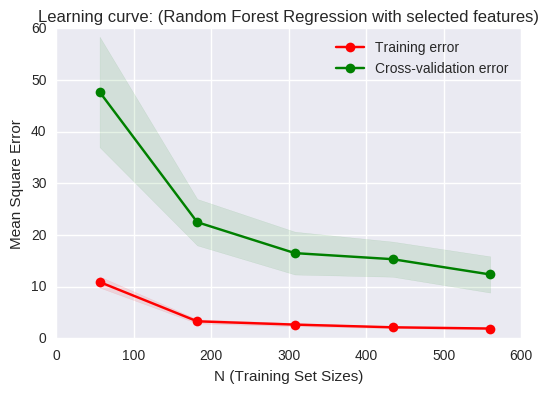

In [45]:
# SelectFromModel with the best threshold
rf_r = rf_r.fit(X_train_transformed, y_train)
model_rf = SelectFromModel(rf_r, threshold=0.000009, prefit=True)

# Feature selection
X_train_new = X_train_selected_rf = model_rf.transform(X_train_transformed)
X_test_selected_rf = model_rf.transform(X_test_transformed)

# Plot the traning curve
title = "Learning curve: (Random Forest Regression with selected features)"
plot_learning_curve(rf_r, title, X_train_new, y_train, cv=5, n_jobs=-1)

In [46]:
# CV performance
rf_score = performance_cv(rf_r, 'rf', X_train=X_train_new)

# Get the names of selected polynomial features
selected_feature_name = [x[0] for x in zip(feature_name, model_rf.get_support()) if x[1]==True]
rf_r = rf_r.fit(X_train_new, y_train)

# Get 'feature' - 'importance' pairs
rf_feature_list = sorted(zip(selected_feature_name, rf_r.feature_importances_), 
                             key=lambda x: abs(x[1]), reverse=True)


# Append to the analysis tuple
analysis_tuple_list.append(('Random forest regression with selected poly 2 features', rf_score, rf_feature_list))


The RMSE cross-validation score of rf is 3.3421406411


### 3.1 Testing on the testing set

### Observation:
* The **ridge regression** model with feature selection performs best on the testing set among all the models, with RMSE score of 1.6563492395142616. I decided to use ridge regression model to make predictions

In [47]:
performance_on_test = []

In [48]:
linear_regression = linear_model.LinearRegression()
linear_regression.fit(X_train, y_train)
performance_on_test.append(performance_test(linear_regression, 'linear regression'))

The RMSE score of the linear regression on test data is 7.06396149505


In [49]:
linear_regression = linear_model.LinearRegression()
linear_regression.fit(X_train, y_train)
performance_on_test.append(performance_test(linear_regression, 'linear regression with polynomial features', 
                                         X_train=X_train_transformed, X_test=X_test_transformed))

The RMSE score of the linear regression with polynomial features on test data is 1.70766292288


In [50]:
linear_regression = linear_model.LinearRegression()
performance_on_test.append(performance_test(linear_regression, 'linear regression with selected features', 
                                         X_train=X_train_selected_lr, X_test=X_test_selected_lr))

The RMSE score of the linear regression with selected features on test data is 1.82385893523


In [51]:
ridge_regression = linear_model.Ridge()
performance_on_test.append(performance_test(ridge_regression, 'ridge regression with selected features', 
                                         X_train=X_train_selected_ridge, X_test=X_test_selected_ridge))

The RMSE score of the ridge regression with selected features on test data is 1.65634923951


In [52]:
rf_r = RandomForestRegressor(n_estimators=50, n_jobs=4)
performance_on_test.append(performance_test(rf_r, 'random forest with selected features', 
                                            X_train=X_train_selected_rf, X_test=X_test_selected_rf))

The RMSE score of the random forest with selected features on test data is 3.67857991461


### 3.2 Make prediction

* Save the result to the scoring_dataset.csv

In [59]:
ridge_regression.fit(np.append(X_train_selected_ridge, X_test_selected_ridge, axis=0), 
                     np.append(y_train, y_test, axis=0))
final_prediction = ridge_regression.predict(data_predict_selected)
raw_predict['Benefice net annuel'] = final_prediction

In [60]:
raw_predict.to_csv('./scoring_dataset.csv', index=False)

In [60]:
titles = [ x[0]  for x in analysis_tuple_list]

In [76]:
titles

['linear regression with plain features',
 'linear regression with poly 2 features',
 'linear regression with selected poly 2 features',
 'Ridge regression with selected poly 2 features',
 'Random forest regression with selected poly 2 features']

In [72]:
performance_on_cv = [ x[1]  for x in analysis_tuple_list]

In [74]:
performance_on_cv

[6.777160861541192,
 2.5226740803448138,
 1.9421305286217563,
 1.8036103841290725,
 3.4254493920109783]

In [75]:
performance_on_test

[7.0639614950460015,
 1.7076629228784177,
 1.8238589352289483,
 1.6563492395142616,
 3.6697110397327934]

In [56]:
feature_importance = [ x[2][0:5]  for x in analysis_tuple_list]

In [59]:
feature_importance

[[('3 portes', -29.0146901481403),
  ('Utilitaire', 28.542294709023718),
  ('SUV', 9.965789753167261),
  ('5 portes', -9.4933943140506827),
  ('Sans emploi', 2.892966415216415)],
 [('Utilitaire Opel', 2.1066481425549926),
  ('Utilitaire Renault', 2.0298160970774646),
  ('Peugeot^2', 1.9058252423707664),
  ('Peugeot', 1.9058252422131381),
  ('Utilitaire Peugeot', 1.8904010707346683)],
 [('age', 250410694.85327202),
  ('age 3 portes', -139117052.75299534),
  ('age 5 portes', -139117052.75277135),
  ('age SUV', -139117052.74033687),
  ('age Utilitaire', -139117052.71879908)],
 [('Etudiant', 0.75218112438757123),
  ('Etudiant^2', 0.75218112438741969),
  ('Ouvrier', -0.62316735244359422),
  ('Ouvrier^2', -0.62316735244308863),
  ('Travailleur non salarie SUV', -0.43491893747994553)],
 [('annual_salary 3 portes', 0.1687603302185029),
  ('standard_of_living 5 portes', 0.13446518547420586),
  ('km_travelled_monthly Utilitaire', 0.076368065925816367),
  ('km_travelled_monthly 3 portes', 0.05946

In [78]:
feature_len = [ len(x[2])  for x in analysis_tuple_list]

In [79]:
feature_len

[24, 325, 248, 245, 195]